In [1]:
#Imports
import sys
sys.path.append('../python/')
#import NGC5533_functions-newmag as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter
#import noordermeer as noord

from datetime import datetime
import time

In [2]:
#import data files:
starttime = time.time()

#TRACING:**************************************
#data points:
data = dp.getXYdata_wXYerr('../NGC_5005/traced_data/ngc5005_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#v_err1=v_err1[:len(v_err1)-1]
#r_dat=r_dat[:len(r_dat)-1]
#v_dat=v_dat[:len(v_dat)-1]
#gas rotmod:
gas_rdata = dp.getXYZdata('rotmod_gas.dat')
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv=np.asarray(rgasv)

#make gas array same length as data points array ????? how can I fit without doing this?????
rgasv=rgasv[:len(rgasv)-5]
rgasv=rgasv[0::72]


#bulge rotmod:
bulge_rdata = dp.getXYZdata('bulge_with_mass.dat')
rbulger = bulge_rdata['xx']
rbulgev = bulge_rdata['zz']
rbulgev=np.asarray(rbulgev)


rbulger=rbulger[:len(rbulger)-14]
rbulger=rbulger[0::66]

rbulgev=rbulgev[:len(rbulgev)-14]
rbulgev=rbulgev[0::66]

#disk rotmod:
disk_rdata = dp.getXYZdata('disk_w_mass.dat')
rdiskr = disk_rdata['xx']
rdiskv = disk_rdata['zz']
rdiskv=np.asarray(rdiskv)

rdiskv=rdiskv[:len(rdiskv)-13]
rdiskv=rdiskv[0::66]

#Halo datathief trace:
halo_dt = dp.getXYdata('../NGC_5005/datatheif_halo_spline.txt')
halo_dtr = halo_dt['xx']
halo_dtv = halo_dt['yy']
halo_dtv=np.asarray(halo_dtv)

halo_dtv=halo_dtv[:len(halo_dtv)-5]
halo_dtv=halo_dtv[0::6]

print(len(r_dat))
print(len(v_dat))
print(len(rgasv))
print(len(rbulgev))
print(len(rdiskv))
print(len(halo_dtv))
print(v_err1)

18
18
18
18
18
18
[29.6832 16.6726 13.5899 11.1151  8.0343 22.251  21.005  21.628  21.564
 20.3858 21.6185 22.2396 20.3972 21.0145 19.7951 19.757  22.8512 20.3991]


In [3]:
# Fitting function, just prefactors for all the components
def g(r,GX,BX,DX,HX):
    return np.sqrt((GX*rgasv)**2 
                   + (BX*rbulgev)**2 
                   + (DX*rdiskv)**2
                   + (HX*halo_dtv)**2)

In [4]:
weighdata=1/v_err1
# LMFit

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Gas
g_params.add('GX', value=1, min=.9, max=1.1) #Mass

#Bulge
g_params.add('BX', value=1, min=0)          #Prefactor

#Disk
g_params.add('DX', value=1, min=0)       #Prefactor
#Halo
g_params.add('HX', value=1, min=0)          #Core radius (kpc)

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [5]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


In [6]:
#smoothing --> creating a spline
#print(bestg)
print(rdiskv)
#for total fit curve
r_dat = r_dat[r_dat.argsort()]
bestg = bestg[r_dat.argsort()]
idx = np.arange(0,np.shape(r_dat)[0])
f_v_T = inter.InterpolatedUnivariateSpline(r_dat[idx%1==0], bestg[idx%1==0], k=5)
f_v_T_v = np.vectorize(f_v_T)

#for gas:
rgasv = rgasv[r_dat.argsort()]
f_v_G = inter.InterpolatedUnivariateSpline(r_dat[idx%1==0], rgasv[idx%1==0], k=5)
f_v_G_v = np.vectorize(f_v_G)

#for disk:
rdiskv = rdiskv[r_dat.argsort()]
f_v_D = inter.InterpolatedUnivariateSpline(r_dat[idx%1==0], rdiskv[idx%1==0], k=5)
f_v_D_v = np.vectorize(f_v_D)

#for bulge:
rbulgev = rbulgev[r_dat.argsort()]
f_v_B = inter.InterpolatedUnivariateSpline(r_dat[idx%1==0], rbulgev[idx%1==0], k=5)
f_v_B_v = np.vectorize(f_v_B)

#for halo:
halo_dtv = halo_dtv[r_dat.argsort()]
f_v_H = inter.InterpolatedUnivariateSpline(r_dat[idx%1==0], halo_dtv[idx%1==0], k=5)
f_v_H_v = np.vectorize(f_v_H)

[147.601569 176.841704 205.18797  223.297656 224.038454 220.444037
 217.298745 216.428603 216.54683  218.112141 216.0983   212.776769
 209.407162 206.134838 201.326213 196.432097 191.367647 186.554538]


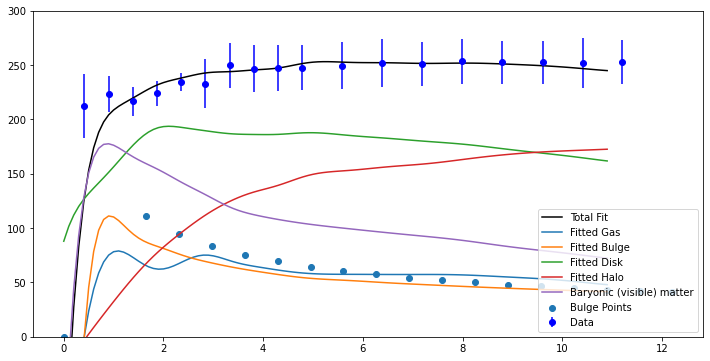

In [7]:
# Define for plotting cont.

rval = np.arange(0,11,0.1)
g_dict = g_fit.best_values
g_g = g_dict['GX']
g_b = g_dict['BX']
g_d = g_dict['DX']
g_h = g_dict['HX']


plt.figure(figsize=(12,6))
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(rval,f_v_T_v(rval),'k',label='Total Fit')
plt.plot(rval,g_g*f_v_G_v(rval),label='Fitted Gas')
plt.plot(rval,g_b*f_v_B_v(rval),label='Fitted Bulge')


plt.scatter(rbulger,g_b*rbulgev,label='Bulge Points') #confusion


plt.plot(rval,g_d*f_v_D_v(rval),label='Fitted Disk')
plt.plot(rval,g_h*f_v_H_v(rval),label='Fitted Halo')
plt.plot(rval,f_v_T_v(rval)-g_h*f_v_H_v(rval),label='Baryonic (visible) matter')

plt.legend(loc='lower right')
plt.ylim(0,300)
plt.show()